# Exploration of EZproxy data 

Updated Mar 14, 2019 

This report was submitted as a record of research progress for a ezproxy data analysis project headed by Lei Jin, Electronic Resources Librarian.


## Background
This project was previously co-chaired by Lei Jin and Dana Thomas, with assistance for a ph.D. student from Mechanical Engineering. The latest member was Josephine Choi, who has joined the project in 2018. She will be responsible for using Python to perform data wrangling as well as data analysis.

The data that was being used here was collected from Sept 2017 to Aug 2018 
 
## Description of the process 


*  Approval from Ethics Board

*  Data from the EZproxy server was obtained by contacting Steven Marsden, RULA's IT Specialist 

*  Data from student data were obtained through CCS 

*  Data was cleaned and merged through the use of python (Separate notebook "Part 1") 

*  Exploratory Data Analysis - which is what this notebook is about

*  Create faculty profile 


## Description of the code in this notebook 

* set the data to correct data type 
* anonymize user date by replacing user_id by a randomized number
* group users from small faculty/academic program to protect their identity 
* create session dataset, which group the activities by one user within 20 minutes


In [1]:
#http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
# import necessary libraries 

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
#%matplotlib inline


In [2]:
df=pd.read_csv("combined_ana_2017-18.csv", parse_dates=True)
df=df.drop('Unnamed: 0',axis=1)
df.columns=["user_id",'access_date','url','domain','acad_prog','prog_yr','on_or_off']

In [ ]:
# session id may need to happen a lot earlier for this work 
g1=df.groupby(['user_id','url','on_or_off',pd.Grouper(key='access_date', freq='20T')]).count()

In [3]:
dff=pd.read_csv("data/acad_prog.csv")

dff=dff.drop(["1","2","3","4","G","Grandtotal"],axis=1)

In [4]:
df=pd.merge(df,dff,on="acad_prog",how="left")
#weird...shouldn't this be df=df.drop(...)
df.drop('acad_prog',axis=1,inplace=True)
df.rename(columns={'acad_prog_c': 'acad_prog'}, inplace=True)
df=df.dropna(subset=['domain','url'])

#df.columns=["user_id",'access_date','url','domain','acad_prog','prog_yr','on_or_off']

## Example
What the processed data looks like. user_id is a random number assigned to protect the user's identity. 

In [194]:
df.head(2)

,user_id,access_date,url,domain,prog_yr,on_or_off,FT/PT,acad_prog,Undergrad,faculty
0,39218.0,2017-09-01 00:00:00,journals.sagepub.com,sagepub.com,G,offcampus,FT,Master of Journalism,Grad,Business
2,15525.0,2017-09-01 00:00:17,pubs.acs.org,acs.org,G,offcampus,FT,Postgrad Biomedical Engineering,Grad,Engineering and Architectural Sci


## Create Session data file 
In addition to the data of clicks, we also create a separate file to analyze the session activities. We group the ezproxy activites by the same user in the same url/domain within 20 minutes as a session. 
This is what the processed session data looks like 

In [ ]:
df.columns=["user_id",'access_date','url','domain','prog_yr','on_or_off','FT/PT',"acad_prog","Undergrad",'faculty']
df['FT/PT']=df['FT/PT'].fillna("Other")
#df['Undergrad'] = df['Undergrad'].astype("category")
df['Undergrad']=df['Undergrad'].fillna("Other")

df['acad_prog']=df['acad_prog'].fillna("staff")
df['faculty']=df['faculty'].fillna("Other")
df['user_id']=df['user_id'].astype(str)
df['user_id']=df['user_id'].fillna('other')
df=df[df.access_date!='date_time']

df.to_csv("data/dff17-18.csv")

In [ ]:
# only run this if starting from this file 
df=pd.read_csv('data/dff17-18.csv')
df=df.drop("Unnamed: 0",axis=1)

In [6]:
# a little bit of cleaning 
df=df[df.access_date!='date_time']
#df.info()
pd.to_datetime(df.access_date)
#set the columns to correct types 
df['user_id']=df['user_id'].astype(str)
df['acad_prog']=df['acad_prog'].fillna("staff")
df['access_date']=df['access_date'].astype('datetime64[ns]')
df['Undergrad'] = df['Undergrad'].astype("category")
df['faculty'] = df['faculty'].astype("category")
df['FT/PT'] = df['FT/PT'].astype("category")
df['acad_prog']=df['acad_prog'].astype("category")

In [28]:
# key code to turn the data into session data
g1=df.groupby(['user_id','url','domain','on_or_off',pd.Grouper(key='access_date', freq='20T')]).count()
g1=pd.DataFrame(g1)

In [33]:
# file is to be exported so that this script doesn't have to be run all the time
g1.to_csv("data/session_raw.csv")

In [112]:
g2=pd.read_csv('data/session_raw.csv')

In [81]:
# clean up to get rid of .0
g2['user_id'],g2['col1']=g2['user_id'].str.split('.',1).str
g2.drop('col1',axis=1,inplace=True)
g2=pd.DataFrame(g2)
g2.reset_index(inplace=True)
#g2.drop('level_0',axis=1,inplace=True)
g2['user_id']=g2['user_id'].astype(str)
g2.drop(['FT/PT',"acad_prog",'Undergrad','faculty'],axis=1,inplace=True)
g2.columns=['user_id','url','domain','on_or_off','access_date','total_per_session']

In [152]:
#have to import the ana key to repopulate the data
ana=pd.read_excel("data/AnanyKey.xlsx")
ana.drop(['USERNAME','Column1'],axis=1,inplace=True)
ana['Usr_id']=ana['Usr_id'].astype(str)
# here comes the merge 
ana=pd.merge(ana,dff,left_on="ACAD_PROG_DESCR",right_on="acad_prog",how="left")
ana.drop('acad_prog',axis=1,inplace=True)
ana.rename(columns={'acad_prog_c': 'acad_prog'}, inplace=True)
ana.drop('ACAD_PROG_DESCR',axis=1,inplace=True)

In [154]:
#second merge
g3=pd.merge(g2,ana,left_on="user_id",right_on="Usr_id",how="left")

In [195]:
g3.head(2)

,user_id,url,domain,on_or_off,access_date,total_per_session,Usr_id,PROGRAM_YEAR,FT/PT,acad_prog,Undergrad,Faculty
0,1,cdn.media.euromonitor.com,euromonitor.com,offcampus,2018-03-27 09:40:00,1,1,2,FT,Retail Management,Undergrad,Business
1,1,cdn.media.euromonitor.com,euromonitor.com,offcampus,2018-05-12 15:00:00,1,1,2,FT,Retail Management,Undergrad,Business


In [156]:
#save the work to save the trouble in the future
g3.to_csv("data/session1718.csv")

# Overall Trend

In [7]:
#only need to run this if start from here 

df=pd.read_csv('data/dff17-18.csv')

# a little bit of cleaning 

df=df[df.access_date!='date_time']

#df.info()

pd.to_datetime(df.access_date)

#set the columns to correct types 
#df['acad_prog']=df['acad_prog'].fillna("staff")

df['access_date']=df['access_date'].astype('datetime64[ns]')
df['on_or_off'] = df['on_or_off'].astype("category")
df['Undergrad'] = df['Undergrad'].astype("category")
df['faculty'] = df['Undergrad'].astype("category")
df['FT/PT'] = df['FT/PT'].astype("category")
#df.info()

In [ ]:
#import datetime as df 
#pd.to_datetime(df.date_time,format='%d-%b-%Y%H:%M:%S')
#df['date_time'] = df['date_time'].apply(lambda x: dt.datetime.strptime(x,'%d-%b-%Y%H:%M:%S'))
#pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f'
#df['date_time'] = df['date_time'].astype('datetime64[ns]')


## Academic Program 

In [8]:

#import datetime as dt
#df['month']=df.access_date[0:7]
#df['access_date'] = df['access_date'].apply(lambda x: dt.datetime.strptime(x,'%d-%b-%Y %H:%M:%S'))
#df.head()

# drop unused data 
df=df.dropna(subset=['url','domain'])


* data was then aggregated by "access_date" and "acad_prog", so that chart could be created based on academic program 

In [158]:
g1=df.groupby([pd.Grouper(key='access_date', freq='D'),'acad_prog'])['acad_prog'].count().unstack().fillna(0)

#http://pbpython.com/pandas-grouper-agg.html


In [162]:
g1.head()

acad_prog,Accounting and Finance,Architectural Science,Arts and Contemporary Studies,Bachelor of Arts,Bachelor of Engineering,Bachelor of Science,Biomedical Sciences,Bus. Mgt. Part-Time,Business Management,Business Special,...,RT Sport Media,RTA New Media,Retail Management,Retail Management Part-time,Ryerson ESL Foundation Program,Social Work,Social Work Part-time,Special Student Status,Urban & Regional Planning,staff
access_date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,128.0,332.0,12.0,607.0,513.0,279.0,28.0,0.0,448.0,0.0,...,0.0,0.0,0.0,0.0,3.0,234.0,0.0,0.0,0.0,13464.0
2017-09-02,19.0,0.0,37.0,755.0,551.0,0.0,12.0,0.0,218.0,0.0,...,0.0,0.0,0.0,0.0,0.0,41.0,0.0,7.0,0.0,12195.0
2017-09-03,6.0,137.0,29.0,585.0,136.0,247.0,5.0,0.0,284.0,0.0,...,0.0,0.0,0.0,0.0,0.0,313.0,0.0,0.0,7.0,13382.0
2017-09-04,273.0,465.0,0.0,1380.0,608.0,55.0,132.0,0.0,171.0,9.0,...,0.0,0.0,0.0,0.0,0.0,163.0,10.0,0.0,35.0,16380.0
2017-09-05,222.0,513.0,990.0,2560.0,749.0,260.0,597.0,0.0,1135.0,0.0,...,8.0,169.0,38.0,0.0,1.0,1213.0,89.0,176.0,339.0,20914.0


In [163]:
g1.to_csv("sample_outcome/g1.csv")

* The graphs below showed that most of the academic program showed similar trend. The only exception is staff. 
* It should be noted that "staff" is the category assigned to all datapoint that could not be mapped with student data we obtained through CCS. While most of the users would be either staff or faculty, it is likely that some students could be erronenously assigned as "staff". 


## Staff vs. Students 

For the graph below, a separate dataframe was created as we need to set the index to "access_date" 
The following graphs help us to explore the differences between student and staff. While staff showed a different pattern, on the whole it does not affect the overall users of the users. 


In [167]:
import matplotlib.pyplot as plt 

In [9]:
# All academic programs
df1=df.set_index("access_date")
GB=df1.groupby(df1.index.date).count()

#GB.head()

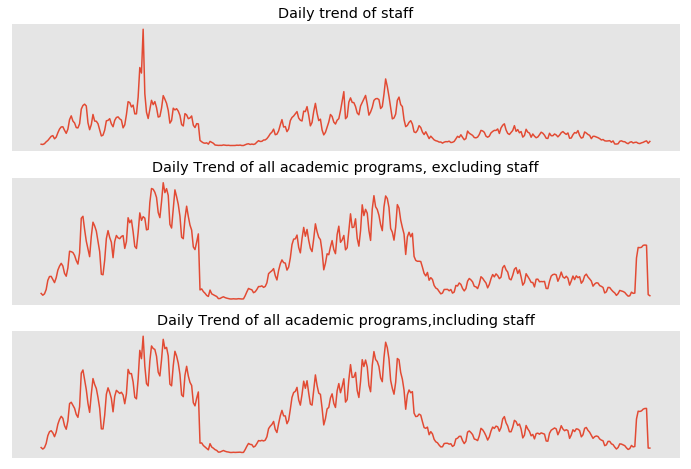

In [14]:
#Staff only
df3=df1[df1.acad_prog=="staff"]
GB1=df3.groupby(df3.index.date).count()

#Not staff
df2=df1[df1.acad_prog!="staff"]
GB4=df2.groupby(df2.index.date).count()

from pylab import *
fig = plt.figure(figsize=(12, 8)) 

subplot(3,1,1)
xticks([]), yticks([])
title('Daily trend of staff')
plt.plot(GB1.index,GB1.user_id)

 
subplot(3,1,2)
xticks([]), yticks([])
title('Daily Trend of all academic programs, excluding staff')
plt.plot(GB4.index,GB4.user_id)
 
    
subplot(3,1,3)
xticks([]), yticks([])
title('Daily Trend of all academic programs,including staff')
plt.plot(GB.index,GB.user_id)
 
fig.savefig('sample_outcome/daily_trend.png')

show()

In [11]:
#plt.style.available
#plt.style.use('ggplot')

<Figure size 576x432 with 0 Axes>

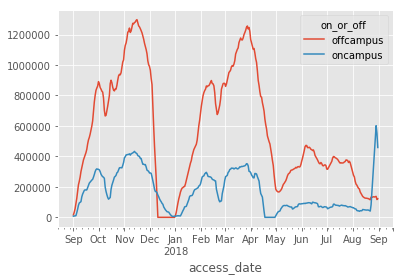

In [15]:
g1=df.groupby([pd.Grouper(key='access_date', freq='D'),'on_or_off'])['on_or_off'].count().unstack().fillna(0)
g1.sample()
plt.figure(figsize=(8,6))
g1.rolling('7D').sum().plot()
fig.savefig('sample_outcome/on_off_trend2017-18.png')
plt.show()

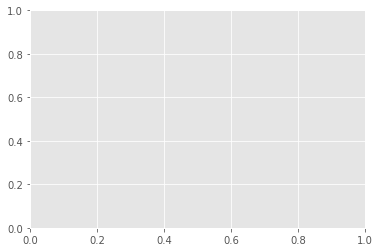

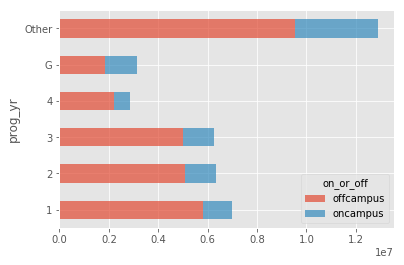

on_or_off  offcampus  oncampus
prog_yr                       
1            5792788   1187062
2            5064208   1269888
3            4984491   1276212
4            2217474    631369
G            1847067   1296424
Other        9551736   3356273


In [16]:

#from statsmodels.graphics.mosaicplot import mosaic
#fig=plt.gcf()
#fig.set_size_inches(4,6)
#mosaic(df.groupby(["on_or_off",'prog_yr']).size(),labelizer=lambda k:"")
#plt.title("On or off campus and the distribution of program of year")
#plt.show()

fig, ax = plt.subplots()
df5=df.groupby(['prog_yr','on_or_off'])['prog_yr'].count().unstack().fillna(0)
df5.plot.barh(stacked=True,alpha=0.7)
ax.ticklabel_format(useOffset=False, style='plain')
fig.savefig('sample_outcome/program_year_trend2017-18.png')

plt.show()
print(df5)

#sns.barplot(x=


The table below shows the academic programs that are most active in using electronic resources. 

In [171]:
#dfg=df1.groupby(["acad_prog","domain"])['prog_yr'].count().fillna(0)

dfdpt=df.groupby("acad_prog")["user_id"].count()

dfdpt.describe()

dfdpt=pd.DataFrame(dfdpt)
col=["total"]
#dfdpt['acad_prog1']=dfdpt.index.values
dfdpt.columns=col


print("Faculty/Department that are most active")
print(dfdpt["total"].sort_values(ascending=False)[:7])


Faculty/Department that are most active
acad_prog
staff                            12908009
Bachelor of Arts                  4175517
Business Management               2389397
Bachelor of Engineering           1431940
Collaborative Nursing Ryerson     1194688
Social Work                        959254
Bachelor of Science                957136
Name: total, dtype: int64


In [ ]:
#df1=df.set_index('access_date')
#df1.drop(['user_id','url','domain'],axis=1)
#df1.groupby(df.index.month.sum().head(10)
#g = df1.groupby(pd.Grouper(freq="M"))
#GB=DF.groupby([(DF.index.year),(DF.index.month)]).count()
#g.sum()

In [ ]:
#g1=df.groupby(['on_or_off', pd.Grouper(key='access_date', freq='D')])['acad_prog'].count()
#http://pbpython.com/pandas-grouper-agg.html
#display(g1)

## Most popular databases domains
The table below shows the Top 10 database domain. 
ProQuest has a much higher number because its domain provided access to 20+ databases. 
Further analysis is required


In [ ]:
dfp2=df.groupby("domain")['user_id'].count()

dfp2=pd.DataFrame(dfp2)
type(dfp2['user_id'])

print("Top 7 Overall Databases")
Top10DbAll=dfp2['user_id'].sort_values(ascending=False)[:7]
print(Top10DbAll)
fig.set_size_inches(4,6)
plt.style.use("ggplot")
Top10DbAll.plot(kind="barh")
plt.title("Top 10 Overall Databases")
fig.savefig('sample_outcome/Top10.png')

plt.show()

## Analysis of use of a particular databases 

In [178]:
dfg=df.groupby(["domain","acad_prog",'prog_yr'])['prog_yr'].count().fillna(0)


In [193]:
dfg.head()


domain                         acad_prog                      prog_yr
18thcjournals.amdigital.co.uk  Arts and Contemporary Studies  1           16
                                                              4           31
                               Bachelor of Arts               1          608
                                                              2           63
                                                              3           32
Name: prog_yr, dtype: int64

In [ ]:
dfg.to_csv("sample_outcome/domain_acad17-18.csv")

Please see Part 4 for details. Above is an example of what we can create with these data

# Analysis of Specific Academic Program  
The tables and graphs belows showed the specific details of two academic programs with most use, Business Management and Bachelor of Arts. 
Similar table and graphs can be created for other academic program

## Business Management

It should note that there are other business-related academic program, but Business Management is one of the programs that has highest usage stats. 


In [ ]:
#df=df.url.dropna(axis='rows')

In [65]:
dfdpt_bus=dfdpt.filter(like="Bus",axis=0)    

print("Use of ER resources by business departments")
display(dfdpt_bus)

#dfdpt_bus.info()
#dfdpt_bus.plot(kind="barh")
#plt.show()


Use of ER resources by business departments


,total
faculty,
Bus. Mgt. Part-Time,97848
Business Management,2389397
Business Special,2504
Business Tech Mgt CAAT,5901
Business Tech. Mgt. PT,28056
Business Technology Mgt.,259897
BusinessTech Mgt CAAT PT,2693
MBA Business Administration,5449
MBA Business Administration PT,38713


The table graph below showed the most widely used databases domain for business management. 

In [20]:
dfbus=df[df['acad_prog']=="Business Management"]

#dfbus.info()
dfdpt_bus=dfbus.groupby("domain")['user_id'].count()

dfdpt_bus=pd.DataFrame(dfdpt_bus)
#dfdpt_bus.head()

Top 10 Overall Databases for Business Management
domain
proquest.com                    487432
jstor.org                       277075
lexis.com                       122122
journals.scholarsportal.info    114550
euromonitor.com                 101585
galegroup.com                    88722
clients1.ibisworld.ca            80162
lexisnexis.com                   77778
mergentonline.com                68585
readspeaker.com                  66655
Name: user_id, dtype: int64


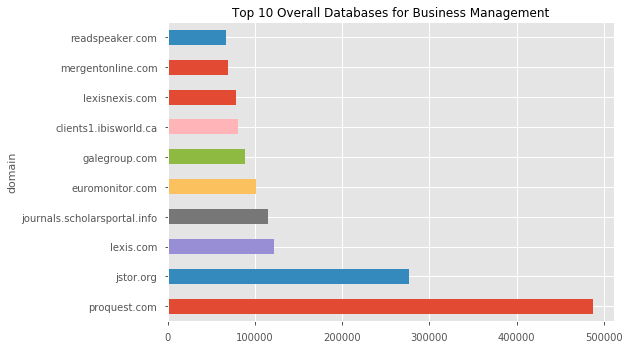

In [21]:
dfpdpt_bus=pd.DataFrame(dfdpt_bus)
type(dfdpt_bus['user_id'])

print("Top 10 Overall Databases for Business Management")
Top10DbBus=dfpdpt_bus['user_id'].sort_values(ascending=False)[:10]
print(Top10DbBus)
Top10DbBus.plot(kind="barh")
plt.title("Top 10 Overall Databases for Business Management")
fig.savefig('sample_outcome/Bus1718_barplot.png')
plt.show()


## Bachelor of Arts 
Similarly, the graph and table below showed the most popular 10 databases domain for students in Bachelor of Arts 


In [18]:
dfart=df[df['acad_prog']=="Bachelor of Arts"]

#dfbus.info()
dfdpt_art=dfart.groupby("domain")['user_id'].count()

dfdpt_art=pd.DataFrame(dfdpt_art)
#dfdpt_bus.head()

Top 10 Overall Databases for Bachelor of Arts
domain
proquest.com                    1115805
jstor.org                        695102
journals.scholarsportal.info     327050
serialssolutions.com             183706
sagepub.com                      163946
wiley.com                        139814
readspeaker.com                  133456
google.com                       109185
galegroup.com                    105219
heinonline.org                   104645
Name: user_id, dtype: int64


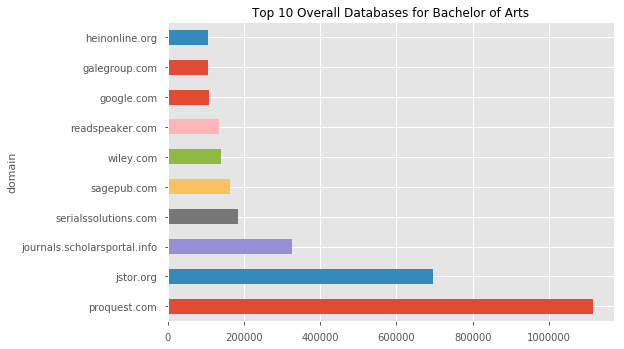

In [19]:
dfpdpt_art=pd.DataFrame(dfdpt_art)
type(dfdpt_art['user_id'])

print("Top 10 Overall Databases for Bachelor of Arts")
Top10DbArt=dfpdpt_art['user_id'].sort_values(ascending=False)[:10]
print(Top10DbArt)
plt.style.use("seaborn-notebook")
Top10DbArt.plot(kind="barh")
plt.title("Top 10 Overall Databases for Bachelor of Arts")
fig.savefig('sample_outcome/BA_1718_barplot.png')

plt.show()